<a href="https://colab.research.google.com/github/hardness1020/Medical_Data_Science_Tutorial/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✨ **Medical Data Science Tutorial**


---


> Turn on the GPU before running the program

## 📁 Download Data and Package (clone the repo if using colab)

---



In [ ]:
# # Download Data
# ! rm -r Medical_Data_Science_Tutorial
# ! git clone https://github.com/hardness1020/Medical_Data_Science_Tutorial.git

Cloning into 'Medical_Data_Science_Tutorial'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 60 (delta 15), reused 51 (delta 11), pack-reused 0
Receiving objects: 100% (60/60), 259.27 KiB | 4.99 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
! pip3 install -r Medical_Data_Science_Tutorial/requirements.txt

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Hyperparameter Optimization
from hyperopt import hp, Trials, space_eval, tpe
from sklearn.metrics import log_loss

# Model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# sklearn acceleration
from sklearnex import patch_sklearn, config_context
patch_sklearn()

from lifelines.utils import concordance_index

# evaluation
from sklearn.metrics import accuracy_score, f1_score

# Self File (using local)
from utils.selected_features import Features
from utils.KM_survival_analysis import KMSurvivalCurve
from utils.get_image_bytes import get_confusion_matrix_bytes
from utils.aml_spliter import AMLSpliter
from utils.hyperparameters.hyperoptimizer import HpOpt

# # Self File (using colab)
# from medical_data_science_tutorial.utils.selected_features import Features
# from medical_data_science_tutorial.utils.KM_survival_analysis import KMSurvivalCurve
# from medical_data_science_tutorial.utils.get_image_bytes import get_confusion_matrix_bytes
# from medical_data_science_tutorial.utils.aml_spliter import AMLSpliter
# from medical_data_science_tutorial.utils.hyperparameters.hyperoptimizer import HpOpt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 🔧 Method

---



### 1. Data Preprocessing

In [ ]:
BASE_PATH = './Medical_Data_Science_Tutorial'
CUTOFF = 2

_ncri_df = pd.read_csv(f'{BASE_PATH}/dataset/NCRI.tsv', sep=' ')
_sg_df = pd.read_csv(f'{BASE_PATH}/dataset/SG.tsv', sep=' ')
features = Features()

#### 1.1 Prepare Cohort for Training and Validation (NCRI)

In [ ]:
# Preprocessing NCRI cohort

ncri_df = _ncri_df.copy().reset_index()
ncri_df = ncri_df.rename(columns={
            'index'     : '病歷號',

            'gender'    : 'Gender',
            'age'       : 'Age',

            'wbc'       : 'WBC',
            'hb'        : 'Hb',
            'plt'       : 'Plt',
            'bm_blasts' : 'PB_Blast',

            # mutations
            'FLT3_TKD'  : 'FLT_TKD',

            'os'        : 'OSD_no_censor_2021',
            'os_status' : 'OS_coding_no_censor_2021',
            'eln_2017'  : 'ELN_2017',
            })

# Lack of mutations : Rad21, STAG1, c-CBL, CBL-b
# Lack of karyotypes: del(5q), t(16;16), t(3;3)
ncri_df['Rad21'] = 0
ncri_df['STAG1'] = 0
ncri_df['c-CBL'] = 0
ncri_df['CBL-b'] = 0
ncri_df['del(5q)'] = 0
ncri_df['t(16;16)'] = 0
ncri_df['t(3;3)'] = 0

# NRAS : "NRAS_other" "NRAS_p.G12_13" "NRAS_p.Q61_62"
# IDH2 : "IDH2_p.R140" "IDH2_p.R172"
# U2AF1: "U2AF1_p.S34" "U2AF1_p.Q157"
ncri_df['NRAS'] = ncri_df[['NRAS_other', 'NRAS_p.G12_13', 'NRAS_p.Q61_62']].any(axis=1).map({True: 1, False: 0})
ncri_df['IDH2'] = ncri_df[['IDH2_p.R140', 'IDH2_p.R172']].any(axis=1).map({True: 1, False: 0})
ncri_df['U2AF1'] = ncri_df[['U2AF1_p.S34', 'U2AF1_p.Q157']].any(axis=1).map({True: 1, False: 0})
ncri_df['ELN_2017'] = ncri_df['ELN_2017'].map({3: 2, 2: 1, 1: 0})

# Select Features
ncri_df = ncri_df[features.reference + features.gender_data + features.age_data + features.blood_data + \
                  features.karyotype_data + features.mutation_data + \
                  ['ELN_2017', 'OSD_no_censor_2021', 'OS_coding_no_censor_2021']]
ncri_df['cohort'] = 'NCRI'

print('Number of sample: ', ncri_df.shape[0])

Number of sample:  2113


<ipython-input-6-8836df6bf2f4>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncri_df['cohort'] = 'NCRI'


In [ ]:
# Filter the data

# Remove the Survival Sample with Observation Period < 2 Month
ncri_df = ncri_df.loc[~((ncri_df['OS_coding_no_censor_2021']==0) & (ncri_df['OSD_no_censor_2021']<CUTOFF)), :].copy()
print('Number of sample after remove the survival sample with observation period < 2 month: ', ncri_df.shape[0])
print()

# Label the Data
OS_adverse_group_threshold = 0.8
OS_intermediate_group_threshold = 4
ncri_df.loc[:, 'OS_label'] =     \
    ncri_df['OSD_no_censor_2021'].map(lambda x: 0 if x < OS_adverse_group_threshold
                                                      else (1 if x < OS_intermediate_group_threshold else 2))
print('Number of adverse     : ', ncri_df[ncri_df['OS_label']==0].shape[0])
print('Number of intermediate: ', ncri_df[ncri_df['OS_label']==1].shape[0])
print('Number of favorable   : ', ncri_df[ncri_df['OS_label']==2].shape[0])

if not os.path.exists('./data_preprocessed'):
    os.makedirs(f'./data_preprocessed')
ncri_df.to_csv(f'./data_preprocessed/NCRI.csv', sep=',', index=False)

Number of sample after remove the survival sample with observation period < 2 month:  2082

Number of adverse     :  710
Number of intermediate:  712
Number of favorable   :  660


#### 1.2 Prepare Cohort for Training and Validation (SG)

In [ ]:
# Preprocessing SG chort

sg_df = _sg_df.copy().reset_index()
sg_df = sg_df.rename(columns={
            'index'     : '病歷號',

            'HB'        : 'Hb',
            'PLT'       : 'Plt',
            'BM_Blasts' : 'PB_Blast',

            # mutations
            'FLT3_TKD'  : 'FLT_TKD',
            'RAD21'     : 'Rad21',

            'OS'        : 'OSD_no_censor_2021',
            'OS_Status' : 'OS_coding_no_censor_2021',
            'eln_2017'  : 'ELN_2017',
            })

# Lack of karyotypes: del(5q), t(16;16), t(3;3), t(8;16)
# Lack of mutations: SMC1A, SMC3, STAG1, c-CBL, CBL-b
sg_df['del(5q)'] = 0
sg_df['t(16;16)'] = 0
sg_df['t(3;3)'] = 0
sg_df['t(8;16)'] = 0
sg_df['SMC1A'] = 0
sg_df['SMC3'] = 0
sg_df['STAG1'] = 0
sg_df['c-CBL'] = 0
sg_df['CBL-b'] = 0

sg_df['ELN_2017'] = sg_df['ELN_2017'].map({'favorable': 2, 'intermediate': 1, 'adverse': 0})

# Select Features
sg_df = sg_df[features.reference + features.gender_data + features.age_data + features.blood_data + \
              features.karyotype_data + features.mutation_data + \
              ['ELN_2017', 'OSD_no_censor_2021', 'OS_coding_no_censor_2021']]
sg_df['cohort'] = 'SG'

print('Number of sample: ', sg_df.shape[0])

Number of sample:  1540


In [ ]:
# Filter the data
# Not Remove the Survival Sample with Observation Period < 2 Month

# Label the Data
OS_adverse_group_threshold = 0.8
OS_intermediate_group_threshold = 4
sg_df.loc[:, 'OS_label'] =     \
    sg_df['OSD_no_censor_2021'].map(lambda x: 0 if x < OS_adverse_group_threshold
                                                      else (1 if x < OS_intermediate_group_threshold else 2))
print('Number of adverse     : ', sg_df[sg_df['OS_label']==0].shape[0])
print('Number of intermediate: ', sg_df[sg_df['OS_label']==1].shape[0])
print('Number of favorable   : ', sg_df[sg_df['OS_label']==2].shape[0])

if not os.path.exists('./data_preprocessed'):
    os.makedirs(f'./data_preprocessed')
sg_df.to_csv(f'./data_preprocessed/SG.csv', sep=',', index=False)

Number of adverse     :  401
Number of intermediate:  580
Number of favorable   :  559


### 2. Training and Prediction

#### 2.1. Config

In [ ]:
# Training and validation Set
preprocessing_df = pd.read_csv(f'./data_preprocessed/NCRI.csv')

# Feature used
feature_types = {
    'gender_age_blood_karyotype_mutation':
          features.gender_data + features.age_data + features.blood_data + \
          features.karyotype_data + features.mutation_data,
}

# Label
label_column = [features.label_data[1]]        # OS_label
time_column  = [features.label_time_data[1]]   # OS_time
event_column = features.label_coding_data[2]   # OS_event

# Set the number of experiments
random_state_list = range(1)

# cohort
cohort = 'NCRI'

#### 2.2 Hyperparameters Optimization
> Train the best combination of hyperparameters

In [ ]:
class HpOptParametersSpace():
    def __init__(self):
        # random forest
        self.rf_cli_params = {
            'n_estimators':             hp.choice('n_estimators', np.arange(100, 1001, 100, dtype=int)),
            'criterion':                hp.choice('criterion', ['gini']),
            'max_depth':                hp.choice('max_depth', np.arange(5, 20, dtype=int)),
            'min_samples_split':        hp.choice('min_samples_split', np.arange(2, 11, dtype=int)),
            'min_samples_leaf':         hp.choice('min_samples_leaf', np.arange(1, 11, dtype=int)),
            'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
            'min_impurity_decrease':    hp.uniform('min_impurity_decrease', 0, 0.5),
            'class_weight':             hp.choice('class_weight', [None, 'balanced']),
            'n_jobs':                   hp.choice('n_jobs', [32]),  # manually set
            'max_features':             hp.choice('max_features', ['sqrt']),
        }

        self.xgb_cli_params = {
            'eta':                  hp.loguniform('eta', -7, 0),
            'max_depth':            hp.choice('max_depth', np.arange(1, 11, dtype=int)),
            'subsample':            hp.uniform('subsample', 0.2, 1),
            'colsample_bytree':     hp.uniform('colsample_bytree', 0.2, 1),
            'colsample_bylevel':    hp.uniform('colsample_bylevel', 0.2, 1),
            'min_child_weight':     hp.loguniform('min_child_weight', -16, 2),
            'alpha':                hp.uniform('alpha', 0, 1),
            'lambda':               hp.uniform('lambda', 0, 1),
            'gamma':                hp.uniform('gamma', 0, 1),
        }

hpo_params_space = HpOptParametersSpace()
hyperopt_loss_func = lambda y, pred: log_loss(y, pred)

In [ ]:
# Training the hyperparameters for XGBoost
fn_name_list = ['rf_cli', 'xgb_cli']
params_list = [hpo_params_space.rf_cli_params, hpo_params_space.xgb_cli_params]
max_evals_list = [256, 256]
best_trial_file_name_list = ['rf', 'xgb']

for feature_name, feature_type in feature_types.items():
    aml_data = AMLSpliter(preprocessing_df, features.reference, feature_type, label_column, feature_name)

    for random_state in random_state_list:
        # Split Training Set and Validation Set
        X_train, X_test, y_train, y_test, train_index, test_index, preprocessor = \
            aml_data.train_test_split_and_normalization_by_cohort(cohorts=['NCRI'], random_state=random_state)

        best_trial_dir_path = f'./ESB_results/best_trial/{cohort}/{CUTOFF}'
        model_dir_path = f'./ESB_results/models/{cohort}/{CUTOFF}/{random_state}'

        for fn_name, params, max_evals, best_trial_file_name in \
                zip(fn_name_list, params_list, max_evals_list, best_trial_file_name_list):
            opt = HpOpt(X_train, X_test, y_train, y_test, hyperopt_loss_func, \
                        random_state, max_evals, feature_name, \
                        best_trial_dir_path, model_dir_path)

            trails = Trials()
            opt.process(fn_name=fn_name, space=params, trials=trails,
                        algo=tpe.suggest, max_evals=max_evals)


            opt.store_best_trial(trails.best_trial, best_trial_file_name, feature_name)

            print(f'[Done] Hyperparameter optimization for {best_trial_file_name} with random state {random_state}\n')

100%|██████████| 256/256 [05:11<00:00,  1.22s/trial, best loss: 0.9168682833635886]
Initialize best trial
[Done] Hyperparameter optimization for rf with random state 0

100%|██████████| 256/256 [01:27<00:00,  2.92trial/s, best loss: 0.9033636091994791]
Initialize best trial
[Done] Hyperparameter optimization for xgb with random state 0



#### 2.3 Training and Prediction
> Use the trained hyperparameters

In [ ]:
# Define the Classifier Model

class Classfier(object):
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def process(self, model, **models_params):
        return getattr(self, model)(**models_params)

    def rf(self, **models_params):
        print('Random Forest model')
        model = RandomForestClassifier(**models_params['rf_params'])
        model.fit(self.X_train, self.y_train)
        self.rf_y_train_pred = model.predict(self.X_train)
        self.rf_y_train_pred_proba = model.predict_proba(self.X_train)
        self.rf_y_test_pred = model.predict(self.X_test)
        self.rf_y_test_pred_proba = model.predict_proba(self.X_test)
        return model, self.rf_y_train_pred, self.rf_y_train_pred_proba, self.rf_y_test_pred, self.rf_y_test_pred_proba

    def xgb(self, **models_params):
        print('XGBoost model')
        model = XGBClassifier(gpu_id=0, tree_method='gpu_hist',
                              eval_metric='mlogloss',**models_params['xgb_params'])
        model.fit(self.X_train, self.y_train, verbose=False)
        self.xgb_y_train_pred = model.predict(self.X_train)
        self.xgb_y_train_pred_proba = model.predict_proba(self.X_train)
        self.xgb_y_test_pred = model.predict(self.X_test)
        self.xgb_y_test_pred_proba = model.predict_proba(self.X_test)
        return model, self.xgb_y_train_pred, self.xgb_y_train_pred_proba, self.xgb_y_test_pred, self.xgb_y_test_pred_proba

    def loss_function_based_ensemble(self, **models_params):
        print('Loss function based ensemble model')
        # print(models_params)

        train_pred_probas = []
        test_pred_probas = []
        model_weights = []

        if 'rf_params' in models_params:
            rf_loss = hyperopt_loss_func(self.y_train, self.rf_y_train_pred_proba)
            train_pred_probas.append(self.rf_y_train_pred_proba)
            test_pred_probas.append(self.rf_y_test_pred_proba)
            model_weights.append(np.exp(-rf_loss))
        if 'xgb_params' in models_params:
            xgb_loss = hyperopt_loss_func(self.y_train, self.xgb_y_train_pred_proba)
            train_pred_probas.append(self.xgb_y_train_pred_proba)
            test_pred_probas.append(self.xgb_y_test_pred_proba)
            model_weights.append(np.exp(-xgb_loss))

        # calculate weights of each model
        model_weights = np.array(model_weights)
        model_weights /= np.sum(model_weights)

        y_train_pred_proba = np.zeros_like(train_pred_probas[0])
        for i, pred in enumerate(train_pred_probas):
            y_train_pred_proba += model_weights[i] * pred

        y_test_pred_proba = np.zeros_like(test_pred_probas[0])
        for i, pred in enumerate(test_pred_probas):
            y_test_pred_proba += model_weights[i] * pred

        y_train_pred = np.argmax(y_train_pred_proba, axis=1)
        y_test_pred = np.argmax(y_test_pred_proba, axis=1)
        return model_weights, y_train_pred, y_train_pred_proba, y_test_pred, y_test_pred_proba

In [ ]:
# Decide which models you want to use

used_models = {
    'rf'    : 'rf_best_trials_dict',
    'xgb'   : 'xgb_best_trials_dict',
}

for feature_name, feature_type in feature_types.items():
    print(f'Feature: {feature_name}')

    # Eq: trials_dict = {random_state: best_trial}
    for model_type, dict_name in used_models.items():
        trials_dict = pickle.load(open(f'./ESB_results/best_trial/{cohort}/{CUTOFF}/{model_type}.{feature_name}.pkl', 'rb'))
        globals()[dict_name] = trials_dict

    for random_state in random_state_list:
        print(f'Random state: {random_state}')

        # Get best trial with specific random state
        # and then convert hyperopt best params dict from {'': ['']} to {'': ''}
        # and then get the real parameters of best trial
        models = {}
        for model_type, dict_name in used_models.items():
            best_trial = globals()[dict_name][random_state]
            best_params_dict = {k: v[0] if isinstance(v, list) and len(v) == 1 else v for k, v in best_trial['misc']['vals'].items()}
            best_params = space_eval(getattr(hpo_params_space, f'{model_type}_cli_params'), best_params_dict)
            models[model_type] = {f'{model_type}_params': best_params}

        # Split the data into train and test set by cohort
        cohorts = cohort.split('_')
        aml_data = AMLSpliter(preprocessing_df, features.reference, feature_type, label_column, feature_name)
        X_train, X_test, y_train, y_test, train_index, test_index, preprocessor = \
            aml_data.train_test_split_and_normalization_by_cohort(cohorts=cohorts, random_state=random_state)

        # Classfication
        classfier = Classfier(X_train, X_test, y_train, y_test)

        # Calculate each of the models
        ensemble_params = {}
        for model_name, model_params in models.items():
            # Process the model
            model, y_train_pred, y_train_pred_proba, y_test_pred, y_test_pred_proba = \
                classfier.process(model_name, **model_params)
            ensemble_params.update(model_params)

            # Save the Model
            model_file_path = f'./ESB_results/models/{cohort}/{CUTOFF}/{random_state}/{model_name}.{feature_name}.pkl'
            if not os.path.exists(os.path.dirname(model_file_path)):
                os.makedirs(os.path.dirname(model_file_path))
            pickle.dump(model, open(model_file_path, 'wb'))

            # Save the training set prediction result
            prediction_df = pd.DataFrame({
                'sample': preprocessing_df.loc[train_index, features.reference[0]],
                'cohort': preprocessing_df.loc[train_index, 'cohort'],
                'label': y_train,
                'prediction': y_train_pred,
                'prediction_proba_adverse': y_train_pred_proba[:, 0],
                'prediction_proba_intermediate': y_train_pred_proba[:, 1],
                'prediction_proba_favorable': y_train_pred_proba[:, 2],
                'ELN_2017': preprocessing_df.loc[train_index, 'ELN_2017'],
            })
            prediction_file_path = f'./ESB_results/prediction/train/{cohort}/{CUTOFF}/{random_state}/{model_name}.{feature_name}.csv'
            if not os.path.exists(os.path.dirname(prediction_file_path)):
                os.makedirs(os.path.dirname(prediction_file_path))
            prediction_df.to_csv(prediction_file_path, index=False)

            # Save the validation set prediction result
            prediction_df = pd.DataFrame({
                'sample': preprocessing_df.loc[test_index, features.reference[0]],
                'cohort': preprocessing_df.loc[test_index, 'cohort'],
                'label': y_test,
                'prediction': y_test_pred,
                'prediction_proba_adverse': y_test_pred_proba[:, 0],
                'prediction_proba_intermediate': y_test_pred_proba[:, 1],
                'prediction_proba_favorable': y_test_pred_proba[:, 2],
                'ELN_2017': preprocessing_df.loc[test_index, 'ELN_2017'],
            })
            prediction_file_path = f'./ESB_results/prediction/test/{cohort}/{CUTOFF}/{random_state}/{model_name}.{feature_name}.csv'
            if not os.path.exists(os.path.dirname(prediction_file_path)):
                os.makedirs(os.path.dirname(prediction_file_path))
            prediction_df.to_csv(prediction_file_path, index=False)


        # Ensemble models
        # print(ensemble_params)
        if len(ensemble_params) > 1:
            model_weights, y_train_pred, y_train_pred_proba, y_test_pred, y_test_pred_proba = \
                classfier.process('loss_function_based_ensemble', **ensemble_params)

            # Save the models' weight
            pickle.dump(model_weights, open(f'./ESB_results/models/{cohort}/{CUTOFF}/{random_state}/weights.{feature_name}.pkl', 'wb'))

            # Save the training set prediction result
            prediction_df = pd.DataFrame({
                'sample': preprocessing_df.loc[train_index, features.reference[0]],
                'cohort': preprocessing_df.loc[train_index, 'cohort'],
                'label': y_train,
                'prediction': y_train_pred,
                'prediction_proba_adverse': y_train_pred_proba[:, 0],
                'prediction_proba_intermediate': y_train_pred_proba[:, 1],
                'prediction_proba_favorable': y_train_pred_proba[:, 2],
                'ELN_2017': preprocessing_df.loc[train_index, 'ELN_2017'],
            })
            prediction_file_path = f'./ESB_results/prediction/train/{cohort}/{CUTOFF}/{random_state}/ensemble.{feature_name}.csv'
            prediction_df.to_csv(prediction_file_path, index=False)

            # Save the validation set prediction result
            prediction_df = pd.DataFrame({
                'sample': preprocessing_df.loc[test_index, features.reference[0]],
                'cohort': preprocessing_df.loc[test_index, 'cohort'],
                'label': y_test,
                'prediction': y_test_pred,
                'prediction_proba_adverse': y_test_pred_proba[:, 0],
                'prediction_proba_intermediate': y_test_pred_proba[:, 1],
                'prediction_proba_favorable': y_test_pred_proba[:, 2],
                'ELN_2017': preprocessing_df.loc[test_index, 'ELN_2017'],
            })
            prediction_file_path = f'./ESB_results/prediction/test/{cohort}/{CUTOFF}/{random_state}/ensemble.{feature_name}.csv'
            prediction_df.to_csv(prediction_file_path, index=False)

Feature: gender_age_blood_karyotype_mutation
Random state: 0
Random Forest model
XGBoost model
Loss function based ensemble model


#### 2.4 External Cohort
> Predict the External Cohort

In [ ]:
SG_preprocessing_df = pd.read_csv(f'./data_preprocessed/SG.csv')

cohort = 'NCRI'
external_cohort = 'SG'
used_models = ['rf', 'xgb']

for feature_name, feature_type in feature_types.items():
    for random_state in random_state_list:
        # NTUH data is for get the normalization preprocessor
        aml_data = AMLSpliter(preprocessing_df, features.reference, feature_type, label_column, feature_name)
        _, _, _, _, _, _, preprocessor = \
            aml_data.train_test_split_and_normalization_by_cohort(cohorts=[cohort], random_state=random_state)

        # Get the features and rearrange the columns of the data
        X_external = SG_preprocessing_df[feature_type].copy()

        # Normalize the data
        X_external[features.age_data + features.blood_data] = preprocessor.transform(X_external)

        # Convert the data type to numpy array
        X_external = X_external.values

        # Predict the probability of each model
        y_pred_probas = []
        for model_type in used_models:
            model_path = f'./ESB_results/models/{cohort}/{CUTOFF}/{random_state}/{model_type}.{feature_name}.pkl'
            model = pickle.load(open(model_path, 'rb'))
            y_pred_probas.append(model.predict_proba(X_external))

        # Load the weights of each model
        weights_path = f'./ESB_results/models/{cohort}/{CUTOFF}/{random_state}/weights.{feature_name}.pkl'
        weights = pickle.load(open(weights_path, 'rb'))
        weights = np.array(weights)

        # Ensemble the probability of each model
        y_pred_proba = np.zeros_like(y_pred_probas[0])
        for i, pred in enumerate(y_pred_probas):
            y_pred_proba += weights[i] * pred
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Save the prediction result
        df = SG_preprocessing_df[['病歷號', 'cohort', 'ELN_2017', 'OS_label']]
        df['prediction'] = y_pred
        df = df.rename(columns={'病歷號': 'sample', 'OS_label': 'label'})

        path = f'./ESB_results/prediction/external/{external_cohort}/{CUTOFF}/{random_state}/ensemble.{feature_name}.csv'
        if not os.path.exists(os.path.dirname(path)):
            os.makedirs(os.path.dirname(path))
        df.to_csv(path, sep=',', index=False)

<ipython-input-15-eab76f514318>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = y_pred


## 📊 Analysis

---



### 1. Config and Read Data



In [ ]:
# Config

CUTOFF = '2'
filename = 'ensemble.gender_age_blood_karyotype_mutation.csv'
reference = 'ELN_2017'
random_state_list = range(1)

# The features used in the model
numerical_columns   = ['Age', 'WBC', 'Hb', 'Plt', 'PB_Blast']
categorical_columns = ['Gender', 'PTPN11', 'NRAS', 'KRAS', 'NPM1', 'FLT_TKD', 'MLL', 'KIT', 'RUNX1',
                       'WT1', 'ASXL1', 'IDH1', 'IDH2', 'TET2', 'DNMT3A', 'TP53', 'SF3B1', 'U2AF1',
                       'SRSF2', 'ZRSR2', 'GATA2', 'STAG2', 'PHF6', 'ETV6', 'EZH2', 'BCOR',
                       'Rad21', 'STAG1', 'c-CBL', 'CBL-b', 'SMC1A', 'SMC3',
                       't(8;21)', 'inv(16)', 't(16;16)', 't(9;11)', 't(6;9)', 't(9;22)', 't(8;16)',
                       'inv(3)', 't(3;3)', '-5', 'del(5q)', '-7', '-17']

time_columns = ['OSD_no_censor_2021']
event_columns = ['OS_coding_no_censor_2021']

In [ ]:
# Read the preprocessed data

_NCRI_df = pd.read_csv(f'./data_preprocessed/NCRI.csv')
NCRI_df = _NCRI_df[['病歷號']+numerical_columns+categorical_columns+time_columns+event_columns].copy()
NCRI_df = NCRI_df.rename(columns={'病歷號': 'sample'})

_SG_df = pd.read_csv(f'./data_preprocessed/SG.csv')
SG_df = _SG_df[['病歷號']+numerical_columns+categorical_columns+time_columns+event_columns].copy()
SG_df = SG_df.rename(columns={'病歷號': 'sample'})

In [ ]:
# Read the prediction data

random_state = 0
df_training = pd.read_csv(f'./ESB_results/prediction/train/NCRI/{CUTOFF}/{random_state}/{filename}', sep=',')
df_validation = pd.read_csv(f'./ESB_results/prediction/test/NCRI/{CUTOFF}/{random_state}/{filename}', sep=',')
df_external = pd.read_csv(f'./ESB_results/prediction/external/SG/{CUTOFF}/{random_state}/{filename}', sep=',')

df_training['sample'] = df_training['sample'].astype(str)
df_validation['sample'] = df_validation['sample'].astype(str)
df_external['sample'] = df_external['sample'].astype(str)

# Merge the features
df_training = df_training.merge(NCRI_df, on='sample', how='left')
df_validation = df_validation.merge(NCRI_df, on='sample', how='left')
df_external = df_external.merge(SG_df, on='sample', how='left')

### 2. Performance

In [ ]:
def performance(df):
    # Accuracy
    acc_ELN2017 = accuracy_score(df['label'], df['ELN_2017'])
    acc_ESB = accuracy_score(df['label'], df['prediction'])

    # F1-score
    f1_ELN2017 = f1_score(df['label'], df['ELN_2017'], average='weighted')
    f1_ESB = f1_score(df['label'], df['prediction'], average='weighted')

    # C-index
    cindex_ELN2017 = concordance_index(df[time_columns[0]], df['ELN_2017'], df[event_columns[0]])
    cindex_ESB = concordance_index(df[time_columns[0]], df['prediction'], df[event_columns[0]])

    # Plot survival curve
    kmf_ELN2017 = KMSurvivalCurve(df, time_column=time_columns[0], event_column=event_columns[0],
                                         label_column='ELN_2017', title='ELN 2017')
    kmf_ESB = KMSurvivalCurve(df, time_column=time_columns[0], event_column=event_columns[0],
                                            label_column='prediction', title='Ensemble (ML)')
    byte = kmf_ELN2017.return_survival_curve_bytes()
    byte = kmf_ESB.return_survival_curve_bytes()




    df_performance = pd.DataFrame({
        'model'    : ['ELN 2017', 'Ensemble'],
        'Accuracy' : [f'{acc_ELN2017:.2f}', f'{acc_ESB:.2f}'],
        'F1-score' : [f'{f1_ELN2017:.2f}', f'{f1_ESB:.2f}'],
        'C-index' : [f'{cindex_ELN2017:.2f}', f'{cindex_ESB:.2f}'],
        'p-value (adverse vs. intermediate)' : [f'{kmf_ELN2017.get_pvalue_by_label(0, 1):.1E}', \
                                                f'{kmf_ESB.get_pvalue_by_label(0, 1):.1E}'],
        'p-value (intermediate vs. favorable)' : [f'{kmf_ELN2017.get_pvalue_by_label(1, 2):.1E}', \
                                                  f'{kmf_ESB.get_pvalue_by_label(1, 2):.1E}']
    })

    return df_performance

#### 2.1. Performance of the training set

,model,Accuracy,F1-score,C-index,p-value (adverse vs. intermediate),p-value (intermediate vs. favorable)
0,ELN 2017,0.46,0.45,0.61,1.5E-13,1.4E-08
1,Ensemble,0.95,0.95,0.83,8.9E-206,3.1E-161


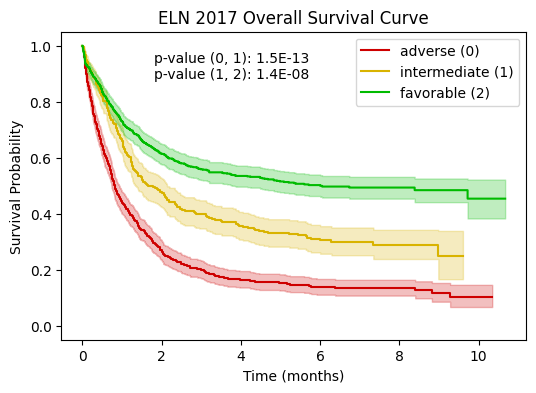

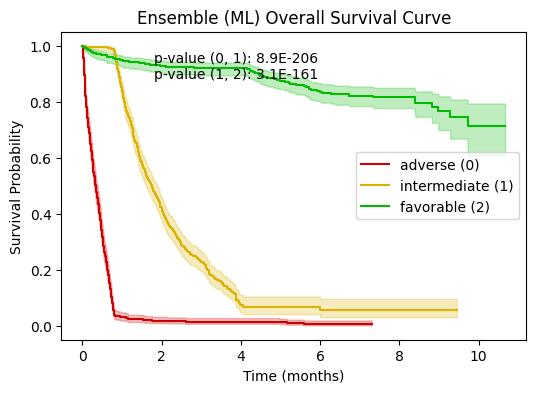

In [ ]:
display(performance(df_training))

#### 2.2. Performance of the validation set

,model,Accuracy,F1-score,C-index,p-value (adverse vs. intermediate),p-value (intermediate vs. favorable)
0,ELN 2017,0.46,0.45,0.61,6.0E-04,7.5E-03
1,Ensemble,0.55,0.55,0.68,9.4E-12,3.3E-06


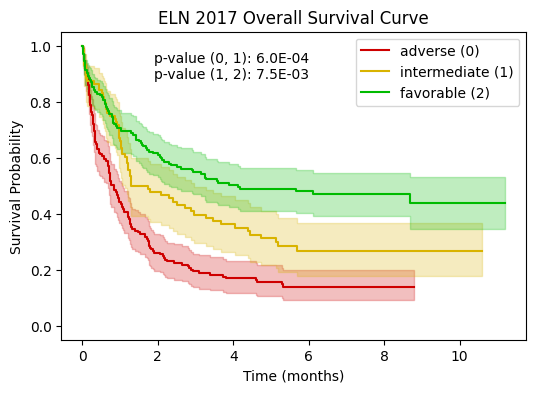

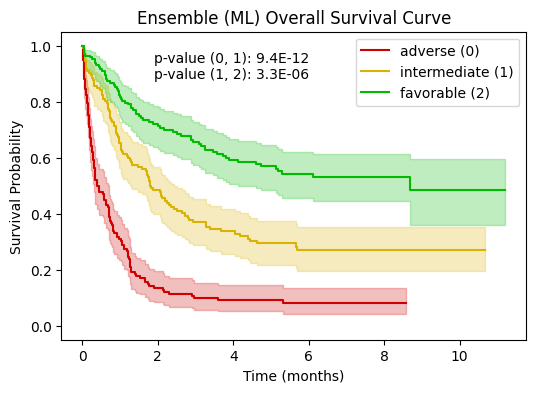

In [ ]:
display(performance(df_validation))

#### 2.2. Performance of the external cohort

,model,Accuracy,F1-score,C-index,p-value (adverse vs. intermediate),p-value (intermediate vs. favorable)
0,ELN 2017,0.45,0.44,0.62,2.5E-06,4.0E-15
1,Ensemble,0.46,0.44,0.62,5.4E-22,5.1E-05


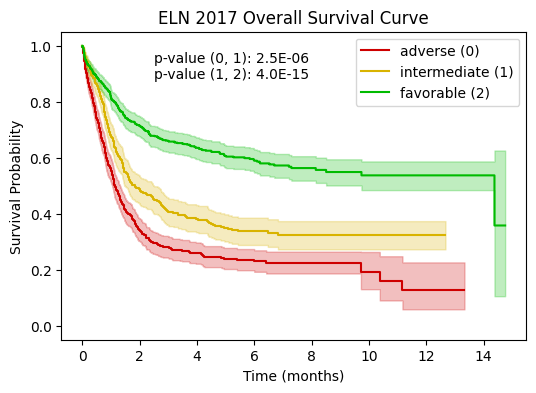

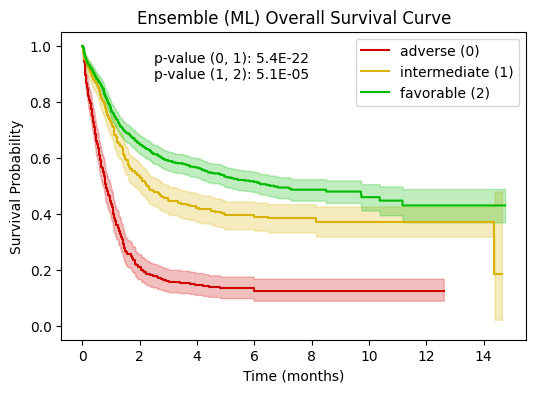

In [ ]:
display(performance(df_external))

### 3. Interpretation

*   Interpret AI models                                  : SHAP
*   Find singnificant features on different group        : T-test...
*   Split the group by features and check survival curve : HSTC
*   Others...